# **Predicting patient no-shows and improving models with synthetic data**
---

## **The data**
Can we predict whether or not someone will show up to an appointment? There is a dataset from Brazil of patients and whether they show up to their hospital checkup appointments: (https://www.kaggle.com/joniarroba/noshowappointments).
The features for each patient are:

* ` PatientId `
* ` AppointmentID `
* ` Gender `
* ` ScheduledDay `
* ` AppointmentDay `
* ` Age `
* ` Neighbourhood `
* ` Scholarship `
* ` Hipertension `
* ` Diabetes `
* ` Alcoholism `
* ` Handcap `
* ` SMS_received `
* ` No-show `


# **The main problems**
When looking at patient dataset has about 100,000 patients, however it is skewed as around t 1/4 of the patients are no shows. Could more No-show patient data improve predictions? Lets see if generating synthetic data can improve predictions.

# **Libraries**

In [2]:
from pycaret.classification import * # Preprocessing, modelling, interpretation, deployment...
import pandas as pd # Basic data manipulation
import dabl as db # Summary plot
from sklearn.model_selection import train_test_split # Data split
from sdv.tabular import CopulaGAN # Synthetic data
from sdv.evaluation import evaluate # Evaluate synthetic data
from btb.tuning import Tunable, GCPTuner # CopulaGAN optimising
from btb.tuning import hyperparams as hp  # Set hyperparameters for optimising
import joblib # Saving preparation steps

# **Importing data**

In [86]:
# Read and output the top 5 rows
hr_data = pd.read_csv('KaggleV2-May-2016.csv')
hr_data.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [87]:
hr_data.rename(columns={'Handcap':'Handicap'},inplace=True)
hr_data.rename(columns={"ScheduledDay":"RegisterDay"},inplace=True)
hr_data.head()

,PatientId,AppointmentID,Gender,RegisterDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [88]:
# convert AppointmentDay from string format to time format
hr_data['AppointmentDay'] = pd.to_datetime(hr_data['AppointmentDay'])

# get month, day name and hour from Start Time after convert
hr_data['Appointment_year'] = hr_data['AppointmentDay'].dt.year
hr_data['Appointment_month'] = hr_data['AppointmentDay'].dt.month
hr_data['Appointment_day'] = hr_data['AppointmentDay'].dt.day
hr_data['Appointment_day_name'] = hr_data['AppointmentDay'].dt.day_name()

hr_data['Appointment_hour'] = hr_data['AppointmentDay'].dt.hour
hr_data.drop('Appointment_hour', axis=1, inplace=True)

#convert RegisterDay from string format to time format
hr_data['RegisterDay'] = pd.to_datetime(hr_data['RegisterDay'])


# get month and day name and hour from Start Time after convert
hr_data['Register_year'] = hr_data['RegisterDay'].dt.year
hr_data['Register_month'] = hr_data['RegisterDay'].dt.month
hr_data['Register_day'] = hr_data['RegisterDay'].dt.day
hr_data['Register_day_name'] = hr_data['RegisterDay'].dt.day_name()
hr_data['Register_hour'] = hr_data['RegisterDay'].dt.hour

hr_data['waiting_time'] = (hr_data['AppointmentDay']-hr_data['RegisterDay']).dt.days

hr_data.head()

,PatientId,AppointmentID,Gender,RegisterDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show,Appointment_year,Appointment_month,Appointment_day,Appointment_day_name,Register_year,Register_month,Register_day,Register_day_name,Register_hour,waiting_time
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No,2016,4,29,Friday,2016,4,29,Friday,18,-1
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No,2016,4,29,Friday,2016,4,29,Friday,16,-1
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No,2016,4,29,Friday,2016,4,29,Friday,16,-1
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,2016,4,29,Friday,2016,4,29,Friday,17,-1
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No,2016,4,29,Friday,2016,4,29,Friday,16,-1


# **Visualising**
As mentioned the main problem with this dataset is a large class imbalance for the target feature `No-show`. I will model the data with the imbalance to see how it performs but there may be a way to improve it, synthetic data generation.

The other features look somewhat normal except some which have zero variance hence will be ignored.

Target looks like classification


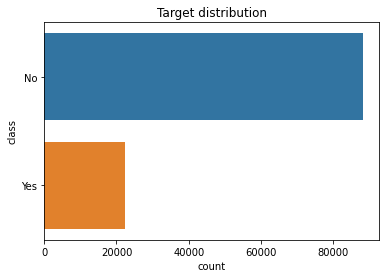

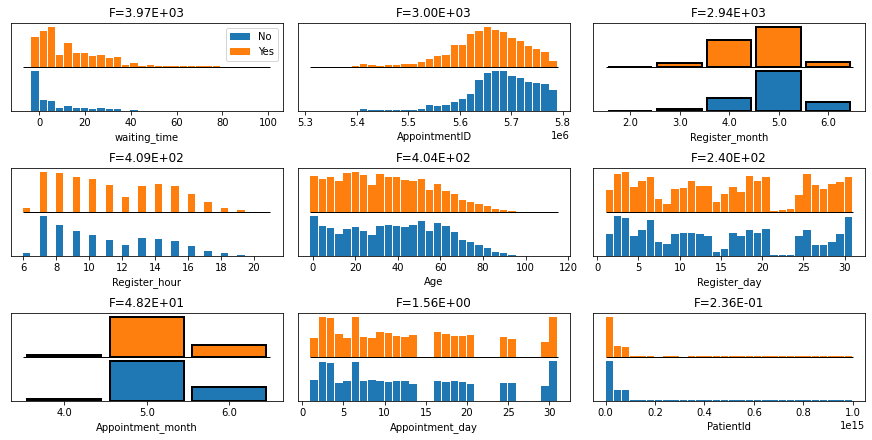

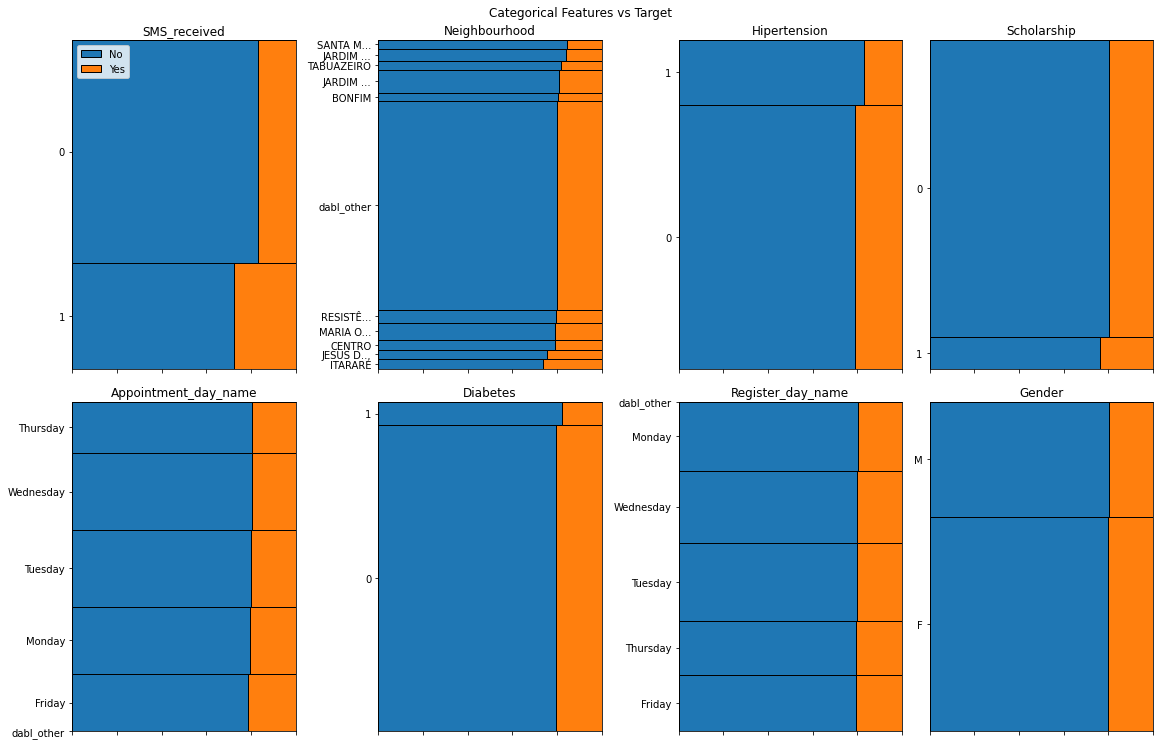

In [90]:
# Plot summaries of continuous + categorical features
## Type hints are used to force types on certain features
types = {"Age" : "continuous", "Appointment_month" : "continuous",
         "Register_hour" : "continuous", "Register_month" : "continuous",
        "waiting_time" : "continuous"}

db.plot(hr_data, y = "No-show", type_hints = types, plot_pairwise = False)



In [91]:
hr_data.head()

,PatientId,AppointmentID,Gender,RegisterDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handicap,SMS_received,No-show,Appointment_year,Appointment_month,Appointment_day,Appointment_day_name,Register_year,Register_month,Register_day,Register_day_name,Register_hour,waiting_time
0,2.987250e+13,5642903,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No,2016,4,29,Friday,2016,4,29,Friday,18,-1
1,5.589978e+14,5642503,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No,2016,4,29,Friday,2016,4,29,Friday,16,-1
2,4.262962e+12,5642549,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No,2016,4,29,Friday,2016,4,29,Friday,16,-1
3,8.679512e+11,5642828,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,2016,4,29,Friday,2016,4,29,Friday,17,-1
4,8.841186e+12,5642494,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No,2016,4,29,Friday,2016,4,29,Friday,16,-1


# **First modelling w/original data**
I'll use `Pycaret` to model the data given it's easy of use and speed. It can handle a lot of the preprocessing, modelling, evaluation and interpretation. Given the dataset is ~1.5k rows the processing isn't too intensive but if it increased in size thankfully Pycaret has GPU functionality.

Ordinal features need to have their levels known and ordered using a dictionary which can quickly be done.

In [92]:
hr_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype              
---  ------                --------------   -----              
 0   PatientId             110527 non-null  float64            
 1   AppointmentID         110527 non-null  int64              
 2   Gender                110527 non-null  object             
 3   RegisterDay           110527 non-null  datetime64[ns, UTC]
 4   AppointmentDay        110527 non-null  datetime64[ns, UTC]
 5   Age                   110527 non-null  int64              
 6   Neighbourhood         110527 non-null  object             
 7   Scholarship           110527 non-null  int64              
 8   Hipertension          110527 non-null  int64              
 9   Diabetes              110527 non-null  int64              
 10  Alcoholism            110527 non-null  int64              
 11  Handicap              110527 non-null  int64        

A fairly simply ordering per feature. 


Now feature(s) can be initialised
* Target feature
* Continuous features
* Ordinal features
* Categorical features
* Features to ignore

In [94]:
# Target feature
target = "No-show"

# Continuous/numeric features
cont_feats = ["Age", "Appointment_year",  "Appointment_month", "Appointment_day",
              "Register_year", "Register_month", "Register_day",
              "Register_hour", "waiting_time"]

# Ordinal features
ord_feats = {}

# Categorical geatures
cat_feats = ["Gender", "Scholarship", "Hipertension", 
             "Diabetes", "Alcoholism", "Handicap", "SMS_received", 
             "Appointment_day_name", "Register_day_name"]

# Features to ignore
ignore = ["PatientId", "AppointmentID"]

Now with the features initalised they can be fed into pycaret's `setup` function involving steps...
* Feed in data + features
* Normalize continuous features + use `minimax` as the normalization method
* Use stratified k folding on the data
* Remove features with low variance
* Split the data into 70:30 train:test

There a lot on offer but not everything is used here.

In [95]:
# Run pycaret setup
setup(hr_data, 
      target = target,
      train_size = 0.7, 
      fold_strategy = "stratifiedkfold",
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      ignore_features = ignore,
      normalize = True,
      normalize_method = "zscore",
      data_split_stratify = True,
      ignore_low_variance = True,
      silent = True)

,Description,Value
0,session_id,6684
1,Target,No-show
2,Target Type,Binary
3,Label Encoded,"No: 0, Yes: 1"
4,Original Data,"(110527, 24)"
5,Missing Values,False
6,Numeric Features,9
7,Categorical Features,10
8,Ordinal Features,True
9,High Cardinality Features,False


({'USI',
  'X',
  'X_test',
  'X_train',
  '_all_metrics',
  '_all_models',
  '_all_models_internal',
  '_available_plots',
  '_gpu_n_jobs_param',
  '_internal_pipeline',
  '_ml_usecase',
  'create_model_container',
  'data_before_preprocess',
  'display_container',
  'exp_name_log',
  'experiment__',
  'fix_imbalance_method_param',
  'fix_imbalance_param',
  'fold_generator',
  'fold_groups_param',
  'fold_param',
  'fold_shuffle_param',
  'gpu_param',
  'html_param',
  'imputation_classifier',
  'imputation_regressor',
  'iterative_imputation_iters_param',
  'log_plots_param',
  'logging_param',
  'master_model_container',
  'n_jobs_param',
  'prep_pipe',
  'pycaret_globals',
  'seed',
  'stratify_param',
  'target_param',
  'transform_target_method_param',
  'transform_target_param',
  'y',
  'y_test',
  'y_train'},
 'clf-default-name',
 'lightgbm',
 StratifiedKFold(n_splits=10, random_state=6684, shuffle=False),
 <MLUsecase.CLASSIFICATION: 1>,
 None,
 False,
 10,
 False,
 [],
 Pipe

Now it's "setup", I like to use `compare_models` to get a rough idea as to which model(s) might be best for this particular use case. The particular metrics I'm looking at are `AUC`, `Precision` and `Recall`. `Recall` is most important as we want to make sure we are correctly identifying the **true negatives** i.e. those that might leave in 6 months. Cross validation is also used.

In [96]:
compare_models(sort = "AUC")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8026,0.7461,0.0778,0.5843,0.1372,0.0942,0.1582,14.8660
lightgbm,Light Gradient Boosting Machine,0.8015,0.7433,0.0376,0.6444,0.0711,0.0500,0.1204,39.9150
xgboost,Extreme Gradient Boosting,0.8003,0.7431,0.0920,0.5332,0.1569,0.1035,0.1567,6.8640
rf,Random Forest Classifier,0.8022,0.7411,0.1601,0.5339,0.2463,0.1690,0.2100,4.0680
gbc,Gradient Boosting Classifier,0.7984,0.7332,0.0067,0.6078,0.0132,0.0086,0.0463,3.8430
ada,Ada Boost Classifier,0.7976,0.7282,0.0168,0.4630,0.0323,0.0186,0.0557,0.9240
et,Extra Trees Classifier,0.7905,0.7260,0.1991,0.4573,0.2773,0.1765,0.1974,6.2060
lda,Linear Discriminant Analysis,0.7910,0.6810,0.0436,0.3569,0.0776,0.0353,0.0613,1.3680
lr,Logistic Regression,0.7954,0.6784,0.0250,0.3980,0.0471,0.0236,0.0552,5.5180
knn,K Neighbors Classifier,0.7778,0.6744,0.2076,0.4030,0.2739,0.1583,0.1705,9.4310


# **How to potentially solve this problem**
So the `lr` model isn't the best. Hyperparameter tuning wasn't great.

More data seems to be preached a lot but what if you can't? **GENERATE IT**.

The problem is making sure the data generated shares similar characteristics as the original data. Thankfully this can be evaluated.

I've decided to generate synthetic data only for people that have left in the last 6 months i.e. `No-show == "Yes"` to lessen the class imbalance.

# **Generating synthetic data**
There's a useful library `sdev` [Synthetic Data Generation](https://github.com/sdv-dev/SDV) to generate synthetic tabular data. I've played around with it specifically the `CopulaGAN` model.

The general idea is to provide a `primary key` and to then run the model for so many `epochs`. There are hyperparameters to tune
* `epochs`
* `batch_size`
* `embedding_dim`
* `gen_dim`
* `dis_dim`
* `l2scale` (omitted in this experiment)



Rather than running a CopulaGAN without hyperparameters or guessing hyperparameters I've leveraged `BTB` [Bayesian Tuning and Bandits](https://github.com/MLBazaar/BTB) which is an optimisation library. To start I'll initialise the `GCPTuner` which is used to declare the hyperparameters to tune. Then the hyperparameters can be called using `propose` from BTB.

In [114]:
tuner = GCPTuner(Tunable({
          'epochs': hp.IntHyperParam(min = 1, max = 2),
          'batch_size' : hp.IntHyperParam(min = 1, max = 100),
          'embedding_dim' : hp.IntHyperParam(min = 1, max = 100),
          'gen' : hp.IntHyperParam(min = 1, max = 1000),
          'dim_gen' : hp.IntHyperParam(min = 1, max = 1000)
        }))

In [115]:
hr_data.info()
hr_data.drop('RegisterDay', axis=1, inplace=True)
hr_data.drop('AppointmentDay', axis=1, inplace=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   PatientId             110527 non-null  float64
 1   AppointmentID         110527 non-null  int64  
 2   Gender                110527 non-null  object 
 3   Age                   110527 non-null  int64  
 4   Neighbourhood         110527 non-null  object 
 5   Scholarship           110527 non-null  int64  
 6   Hipertension          110527 non-null  int64  
 7   Diabetes              110527 non-null  int64  
 8   Alcoholism            110527 non-null  int64  
 9   Handicap              110527 non-null  int64  
 10  SMS_received          110527 non-null  int64  
 11  No-show               110527 non-null  object 
 12  Appointment_year      110527 non-null  int64  
 13  Appointment_month     110527 non-null  int64  
 14  Appointment_day       110527 non-null  int64  
 15  

KeyError: "['RegisterDay'] not found in axis"

With the tuner ready it's as simple as creating a training loop and then calling the tuner within the loop and feeding the hyperparameters into the CopulaGAN.

In [122]:
best_score = float('-inf') # Keep track of best score
tracker = 0 # Keep track of how many loops have completed
best_params = 0
real = hr_data[hr_data["No-show"] == "Yes"] # Filter to only those employees that left

## TRAINING LOOP START ##
for _ in range(10):
  print(_)
  # Increment the tracker
  tracker += 1

  # Every 5 loops output the tracker
  if tracker % 5 == 0:
    print(tracker)

  # Get the hyperparameters for this loop
  proposal = tuner.propose(1)
  
  # Create the CopulaGAN
  # NOTE - batch_size is multiplied by 10 as needs to be a factor of 10
  model = CopulaGAN(primary_key = "AppointmentID", 
                    embedding_dim = proposal['embedding_dim'],
                    generator_dim = (proposal['gen'], proposal['gen']),
                    discriminator_dim = (proposal['dim_gen'], proposal['dim_gen']),
                    batch_size = proposal['batch_size'] * 10,
                    epochs = proposal['epochs'])
  
  # Fit the CopulaGAN
  model.fit(real)
  
  # Create 600 rows of data
  synth_data = model.sample(40000, max_retries = 300)
  
  # Evaluate the synthetic data against the real data
  score = evaluate(synthetic_data = synth_data, real_data = real)
  print(score)
  # If the new hyperparameters beat the best ones, store them along with the score
  if score > best_score:
    best_params = proposal
    best_score = score

  # Record the hyperparameters and score      
  tuner.record(proposal, score)

## TRAINING LOOP END ##


print('Best score obtained: ', best_score)
print('Best parameters: ', best_params)

0
-127.98326089124481
1
-4.7983101442462994e+29
2
-86.06439633499902
3
-163.5724513644022
4
5
-141.73803723376568
5
-2.312036979416747e+30
6
-1.5526049221877993e+30
7
-8.710170156596934e+29
8
-1.2763638591769957e+30
9
10
-102.63850154923227
Best score obtained:  -86.06439633499902
Best parameters:  {'epochs': 2, 'batch_size': 27, 'embedding_dim': 32, 'gen': 722, 'dim_gen': 67}


In [123]:
model.save('best_copula.pkl')

In [124]:
synth_data.to_csv("synth_data.csv", index = False)

# **Setting up data for round 2**
The real dataset can be split into 60:40 training/test. Once this has been split the synthetic data can be added to the training data. This in a way doesn't "waste" the real dataset in the training.

In [125]:
# Load synth data in
synth_data = pd.read_csv("synth_data.csv")

# Split real data into training + test set
train, test, target_train, target_test = train_test_split(hr_data.drop("No-show", axis = 1), hr_data["No-show"], test_size = 0.4, random_state = 42)

# Add No-show column back into training + test set
train["No-show"] = target_train
test["No-show"] = target_test

# Add the 600 synthetic rows of data to training data + remove dataset column
input = pd.concat([train, synth_data])

In [126]:
print("Training size (real):", train.shape)
print("Training size (fake + real):", input.shape)
print("Testing size (real:", test.shape)

Training size (real): (66316, 22)
Training size (fake + real): (106316, 22)
Testing size (real: (44211, 22)


In [128]:
ord_feats = {}

Now this data can be fed into a new `setup` but this time declaring `test_data` as the test data that was created earlier. 

So there is a combination of **synthetic and real data in the training set** but only real in the test data.

In [129]:
# Run pycaret setup w/synthetic data
setup(input, 
      target = target, 
      test_data = test,
      fold_strategy = "stratifiedkfold",
      train_size = 0.7, 
      numeric_features = cont_feats,
      categorical_features = cat_feats,
      ordinal_features = ord_feats,
      ignore_features = ignore,
      normalize = True,
      normalize_method = "zscore",
      data_split_stratify = True,
      ignore_low_variance = True,
      silent = True, verbose = False)

({'USI',
  'X',
  'X_test',
  'X_train',
  '_all_metrics',
  '_all_models',
  '_all_models_internal',
  '_available_plots',
  '_gpu_n_jobs_param',
  '_internal_pipeline',
  '_ml_usecase',
  'create_model_container',
  'data_before_preprocess',
  'display_container',
  'exp_name_log',
  'experiment__',
  'fix_imbalance_method_param',
  'fix_imbalance_param',
  'fold_generator',
  'fold_groups_param',
  'fold_param',
  'fold_shuffle_param',
  'gpu_param',
  'html_param',
  'imputation_classifier',
  'imputation_regressor',
  'iterative_imputation_iters_param',
  'log_plots_param',
  'logging_param',
  'master_model_container',
  'n_jobs_param',
  'prep_pipe',
  'pycaret_globals',
  'seed',
  'stratify_param',
  'target_param',
  'transform_target_method_param',
  'transform_target_param',
  'y',
  'y_test',
  'y_train'},
 'clf-default-name',
 'lightgbm',
 StratifiedKFold(n_splits=10, random_state=4323, shuffle=False),
 <MLUsecase.CLASSIFICATION: 1>,
 None,
 False,
 10,
 False,
 [],
 Pipe

Now setup the `compare_models` can be checked again. Interestingly the `AUC`, `Recall` and `Precision` all went up considerably. `Recall` nearly doubled!

In [130]:
compare_models(sort = "AUC")

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
catboost,CatBoost Classifier,0.8600,0.9333,0.7607,0.9283,0.7721,0.7213,0.7438,20.4350
xgboost,Extreme Gradient Boosting,0.8552,0.9300,0.7629,0.9094,0.7726,0.7116,0.7324,8.4320
rf,Random Forest Classifier,0.8521,0.9292,0.7843,0.8887,0.7896,0.7052,0.7262,6.8090
lightgbm,Light Gradient Boosting Machine,0.8534,0.9273,0.7582,0.9005,0.7707,0.7079,0.7257,1.0610
et,Extra Trees Classifier,0.8393,0.9183,0.8018,0.8482,0.7943,0.6794,0.6974,11.3390
gbc,Gradient Boosting Classifier,0.8092,0.9063,0.7941,0.8015,0.7782,0.6190,0.6325,6.7790
knn,K Neighbors Classifier,0.8018,0.8786,0.7211,0.8423,0.7494,0.6045,0.6188,22.9010
ada,Ada Boost Classifier,0.7615,0.8589,0.7760,0.7462,0.7521,0.5231,0.5322,1.4690
lr,Logistic Regression,0.7455,0.8153,0.7272,0.7437,0.7262,0.4913,0.4969,5.6890
lda,Linear Discriminant Analysis,0.7457,0.8148,0.7273,0.7446,0.7270,0.4918,0.4973,2.2200


A gradient boosting classifier was decided upon.

# **Conclusion**
Adding synthetic data seems to improve accuracy accross the board.